# TDT4173 - Machine learning project, fall 2021 (long notebook)

## Exploratory data analysis

### Imputations

The starting point of our EDA were methods provided by the TAs for gaining insight into both what features are supposed to represent, and how present (or not) their values are in the dataset.

In [3]:
mhu.describe_data(apartments, apartments_meta)

In [4]:
mhu.describe_data(buildings, buildings_meta)

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


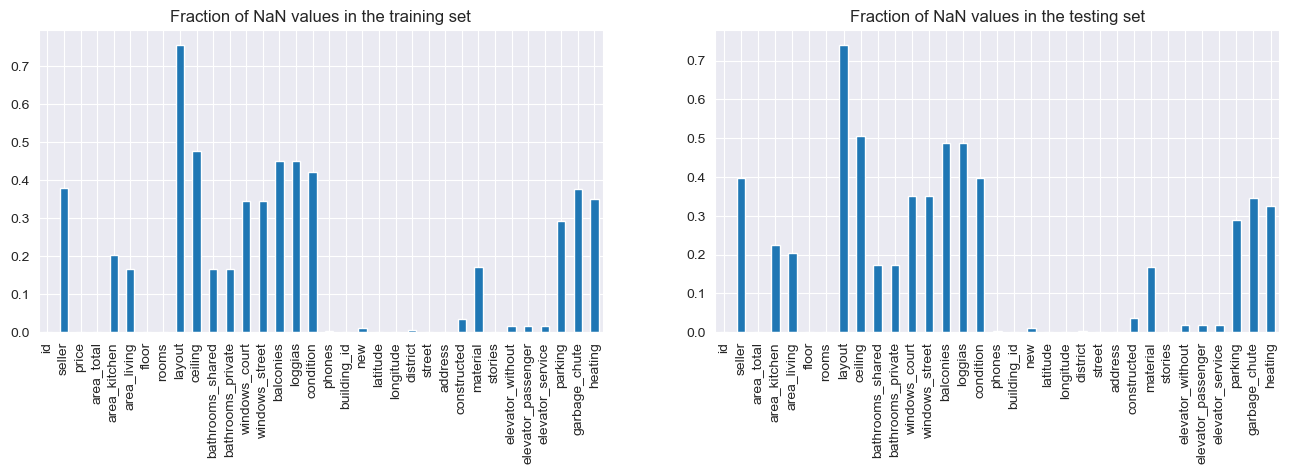

In [5]:
# analyse missing data
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

When imputing values, we would refer to the figures above to determine the best approach.<br>
For each feature, we would examine distribution of values with histograms and box plots (some examples given below). This gave us information about the distribution of values. For categorical variables, we also found value_counts() method useful for a more detailed information.

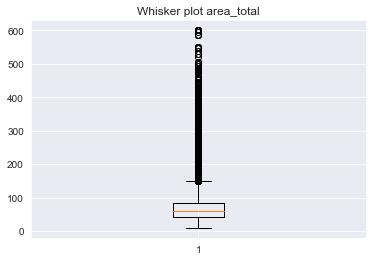

In [10]:
fig1, ax1 = plt.subplots()
ax1.set_title(f'Whisker plot area_total')
ax1.boxplot(data_all['area_total'].dropna());

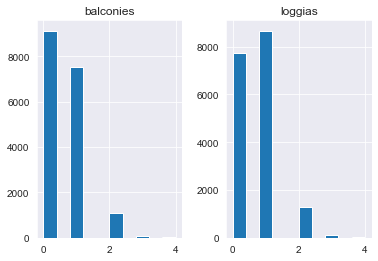

In [32]:
bloggias = data[['balconies', 'loggias']].append(data_test[['balconies', 'loggias']])
# include picture to clarify what is a balcony and what is a loggia in Russia
bloggias.hist();

Here is the summary of the imputed values for each feature separately:
 - seller: categorical, no special imputation. We just replaced NaNs with -1, to treat them as a separate category;
 - area_kitchen: imputed with median value __for the corresponding quartile__. We found this more granular imputation to perform better than regular median, because it woul offset senseless resulting instances (e.g. 30m<sup>2</sup> apartment with a 42m<sup>2</sup> kitchen. We also pruned instances which had similarly incorrect values in the dataset originally (assumingly due to bad collection process). More on that below;
 - area_living: analogous to area_kitchen;
 - layout: with over 70% of data missing, we chose to not impute this feature. We just replaced NaNs with -1;
 - ceiling: impute with median;
 - bathrooms_private and bathrooms_shared: we found the mode of combination of these two variables, and imputed that (bathrooms_private with 1, and bathrooms_shared with 0), since we also believe this to be the most common combination;
 - windows_court and windows_street: analogous to bathrooms;
 - balconies: impute 0.0 (mode)
 - loggias: impute 1.0 (mode)
 - condition: after trying multiple combinations, we decided to simply replace missing values with -1;
 - building_id: technically categorical, but with way to many categories to make sense. Dropping it
 - new: this info is missing in a very small number of cases. It's reasonable to presume omission means it's not a new building;
 - latitude: missing in only two apartments in test dataset, located in the same building, whose address is easily found online, so that was imputed;
 - longitude: same as above;
 - district: locations of buildings were found on Google Maps and imputed manually for 11 missing building instances;
 - street: categorical, label encoded;
 - address: we didn't see any use for this feature, so we omitted it;
 - constructed: imputed with median;
 - material: imputed with mode;
 - elevator_score: I combine all three columns into one, with elevators_without counting as a negative. Before that, I impute NaN rows with 0-1-0 combination, which corresponds to the median score of the actually available data. We found that excluding the original features performs slightly better (or at least not worse), so we omitted them;
 - parking: mputed with 1.0 (underground parking), which is both mode and median
 - garbage_chute: imputing with 1.0 (mode)
 - heating: dominance of central heating is so prevalent that it would be hard to not justify imputing with mode

We checked the feature correlation, and we didn't find any particularly strong ones that we could use. Of course, feature __pairs__ like bathrooms (private and shared), balconies and loggias, and windows (court and street) are negatively correlated, and we took that into consideration when imputing.

<AxesSubplot:>

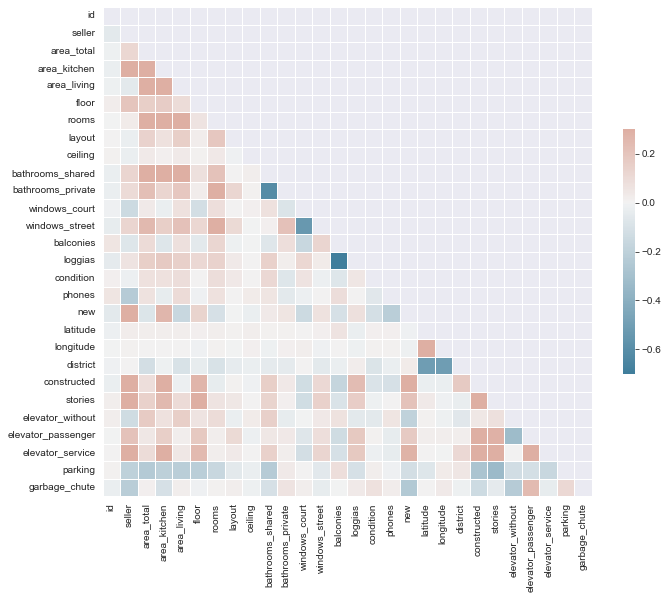

In [17]:
# plot correlation between features

X_train = data.drop(features_to_drop + ['price'], axis=1)
y_train = data.price
X_test = data_test.drop(features_to_drop, axis=1)
X = X_train.append(X_test, ignore_index=True)

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

When looking into locations of apartments, it was easy to spot 7 outliers.

Text(0, 0.5, 'Latitude test')

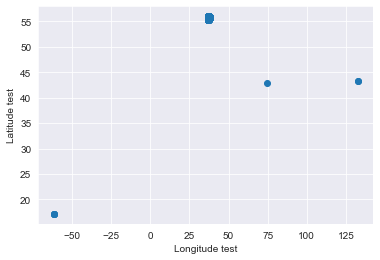

In [34]:
plt.scatter(data_test['longitude'], data_test['latitude'])
plt.xlabel('Longitude test')
plt.ylabel('Latitude test')

In [60]:
not_on_map_test = data_test[data_test['latitude'] < 50]
not_on_map_test

id  seller  area_total  area_kitchen  area_living  floor  rooms  \
2511  25796     NaN        19.8           5.1          9.4   11.0    1.0   
2529  25814     2.0        30.3           NaN          NaN    1.0    1.0   
4719  28004     2.0       167.0          18.0        125.0    5.0    4.0   
5090  28375     0.0        43.6           5.0         28.8    4.0    2.0   
6959  30244     NaN        19.8           5.1          9.4   11.0    1.0   
8596  31881     0.0        27.2           NaN          NaN   17.0    1.0   
9547  32832     NaN       189.0           NaN          NaN    1.0    5.0   

      layout  ceiling  bathrooms_shared  bathrooms_private  windows_court  \
2511     NaN      NaN               NaN                NaN            NaN   
2529     NaN      NaN               NaN                NaN            NaN   
4719     1.0      NaN               1.0                2.0            1.0   
5090     NaN      NaN               NaN                NaN            NaN   
6959     NaN      NaN               NaN                NaN            NaN   
8596     NaN      NaN               1.0                0.0            0.0   
9547     NaN      NaN               NaN                NaN            NaN   

      windows_street  balconies  loggias  condition  phones  building_id  new  \
2511             NaN        NaN      NaN        NaN     1.0         4636  1.0   
2529             NaN        NaN      NaN        NaN     0.0         4202  NaN   
4719             1.0        1.0      0.0        2.0     1.0         8811  0.0   
5090             NaN        NaN      NaN        NaN     0.0         4412  1.0   
6959             NaN        NaN      NaN        NaN     1.0         4636  1.0   
8596             1.0        NaN      NaN        NaN     1.0         4412  1.0   
9547             NaN        NaN      NaN        NaN     NaN         5667  NaN   

       latitude   longitude  district             street address  constructed  \
2511  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
2529  42.914700   74.517184       NaN    улица 1-я Линия      57       2016.0   
4719  43.353545  132.768097       NaN  улица Центральная      75       2007.0   
5090  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
6959  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/1       2021.0   
8596  17.141734  -61.790500       NaN  Бунинские Луга ЖК  к2/2/2       2021.0   
9547  43.352968  132.759204       NaN  улица Центральная      48          NaN   

      material  stories  elevator_without  elevator_passenger  \
2511       3.0     17.0               1.0                 0.0   
2529       NaN      3.0               NaN                 NaN   
4719       NaN      5.0               0.0                 1.0   
5090       NaN      9.0               0.0                 1.0   
6959       3.0     17.0               1.0                 0.0   
8596       NaN      9.0               0.0                 1.0   
9547       NaN      2.0               NaN                 NaN   

      elevator_service  parking  garbage_chute  heating  
2511               0.0      NaN            0.0      NaN  
2529               NaN      NaN            NaN      NaN  
4719               1.0      1.0            1.0      NaN  
5090               1.0      NaN            NaN      NaN  
6959               0.0      NaN            0.0      NaN  
8596               1.0      NaN            NaN      NaN  
9547               NaN      NaN            NaN      NaN

All of these were assigned to a new district, 12.<br>
Other buildings that didn't have values for 'district' feature we imputed by finding them on the map, and assigning them to the nearset district.

(<AxesSubplot:title={'center':'Moscow apartment building_id location'}, xlabel='longitude', ylabel='latitude'>,
 None)

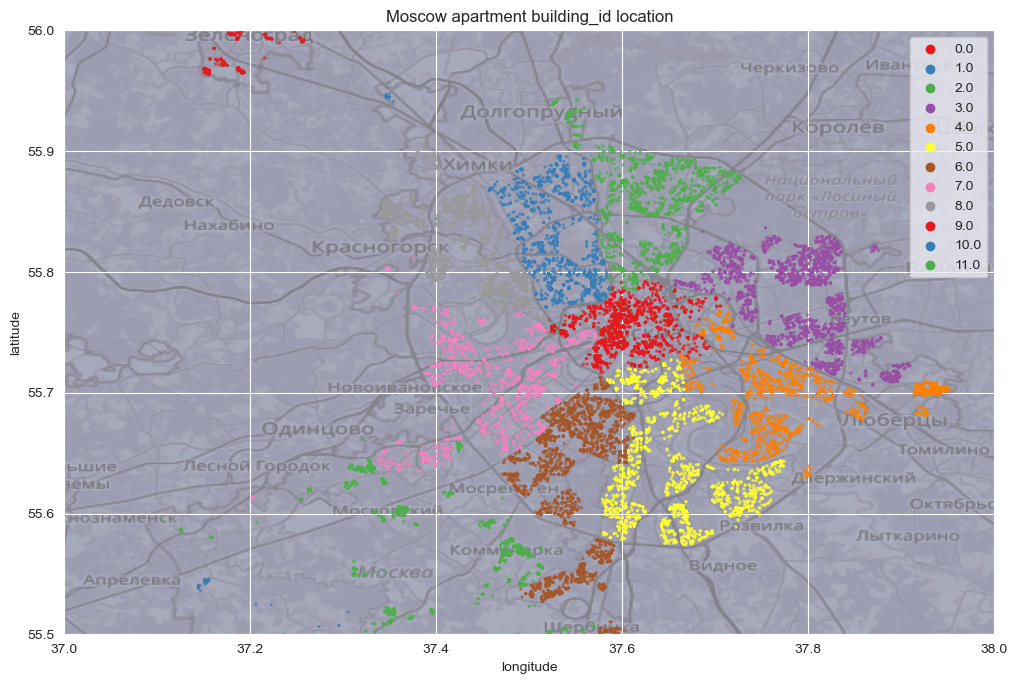

In [80]:
plot_map(X, column='district', cmap='Set1')

(<AxesSubplot:title={'center':'Moscow apartment building_id location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x22182f59520>)

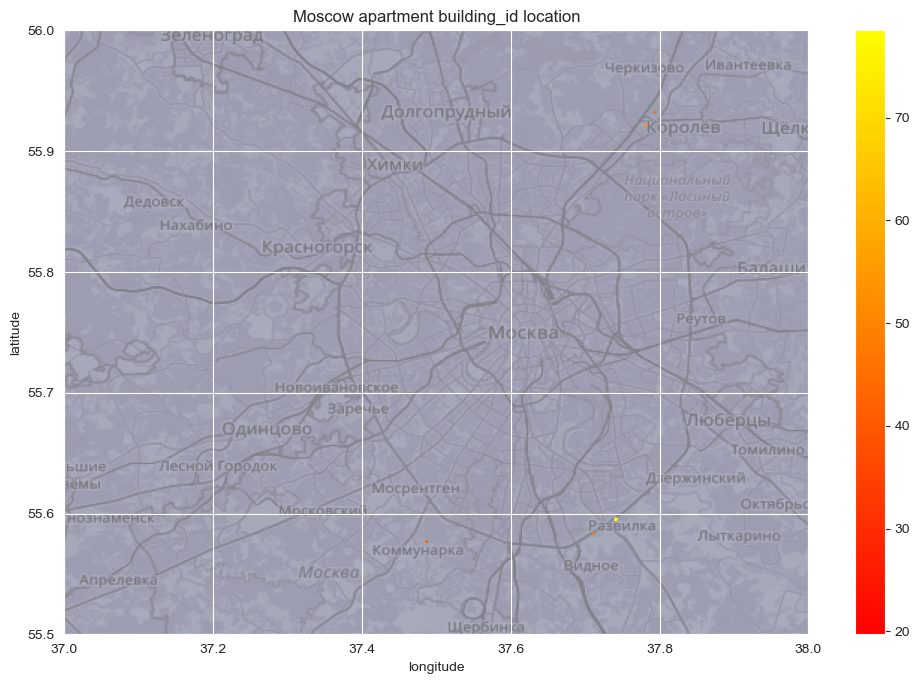

In [64]:
plot_map(X[X['district'].isna()], column='area_total')

Another thing that proved useful early on was domain exploration that would clarify provided metadata about features. There were too many examples to list here and remember now, but one striking revelation was that 'лоджия' in Russia is a very different thing from what a google search for 'loggia' would usually show as top results.

![loggia](img/balkon-i-lodzhiya-kak-otlichit.jpg)

#### General transformations and feature combinations

While transforming features doesn't really make any impact on tree-based algorithms, finding a logarithm of the target variable, apartment price, and bringing it closer to the standard distribution, proved _very_ useful.

C:\Users\matey\miniconda3\envs\mlcourse\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matey\miniconda3\envs\mlcourse\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

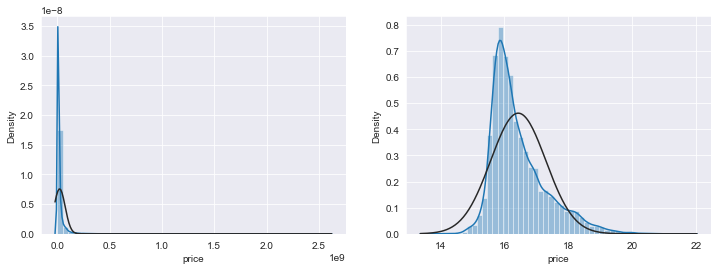

In [19]:
# this is why we train on log transform of price, apparently - it helps with the splits:
# https://stats.stackexchange.com/a/267864
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(data['price'], ax=ax[0], fit=norm)
sns.distplot(np.log(data[('price')]+1), ax=ax[1], fit= norm)

### Geographical EDA

#### EDA: Area data

This notebook explores the different possibillities for imputing numerical area data

In [4]:
def scatter_plot(data, col_1, col_2, col_3, title):
    """
    Function for plotting comparison of the area axes.
    """
    fig = plt.figure(constrained_layout=True, figsize=(10, 4), dpi=200)
    gs = GridSpec(1, 3, figure=fig)
    ax_1 = fig.add_subplot(gs[0, 0])
    ax_2 = fig.add_subplot(gs[0, 1])
    ax_3 = fig.add_subplot(gs[0, 2])

    ax_1.scatter(data[col_1], data[col_2], s=0.5)
    ax_1.set_xlabel('{}'.format(col_1))
    ax_1.set_ylabel('{}'.format(col_2))
    ax_1.axline((0, 0), (100, 100), c='k', lw=0.5)

    ax_2.scatter(data[col_1], data[col_3], s=0.5)
    ax_2.set_xlabel('{}'.format(col_1))
    ax_2.set_ylabel('{}'.format(col_3))
    ax_2.axline((0, 0), (100, 100), c='k', lw=0.5)

    ax_3.scatter(data[col_2], data[col_3], s=0.5)
    ax_3.set_xlabel('{}'.format(col_2))
    ax_3.set_ylabel('{}'.format(col_3))

    fig.suptitle(title)
    plt.show()

##### First view

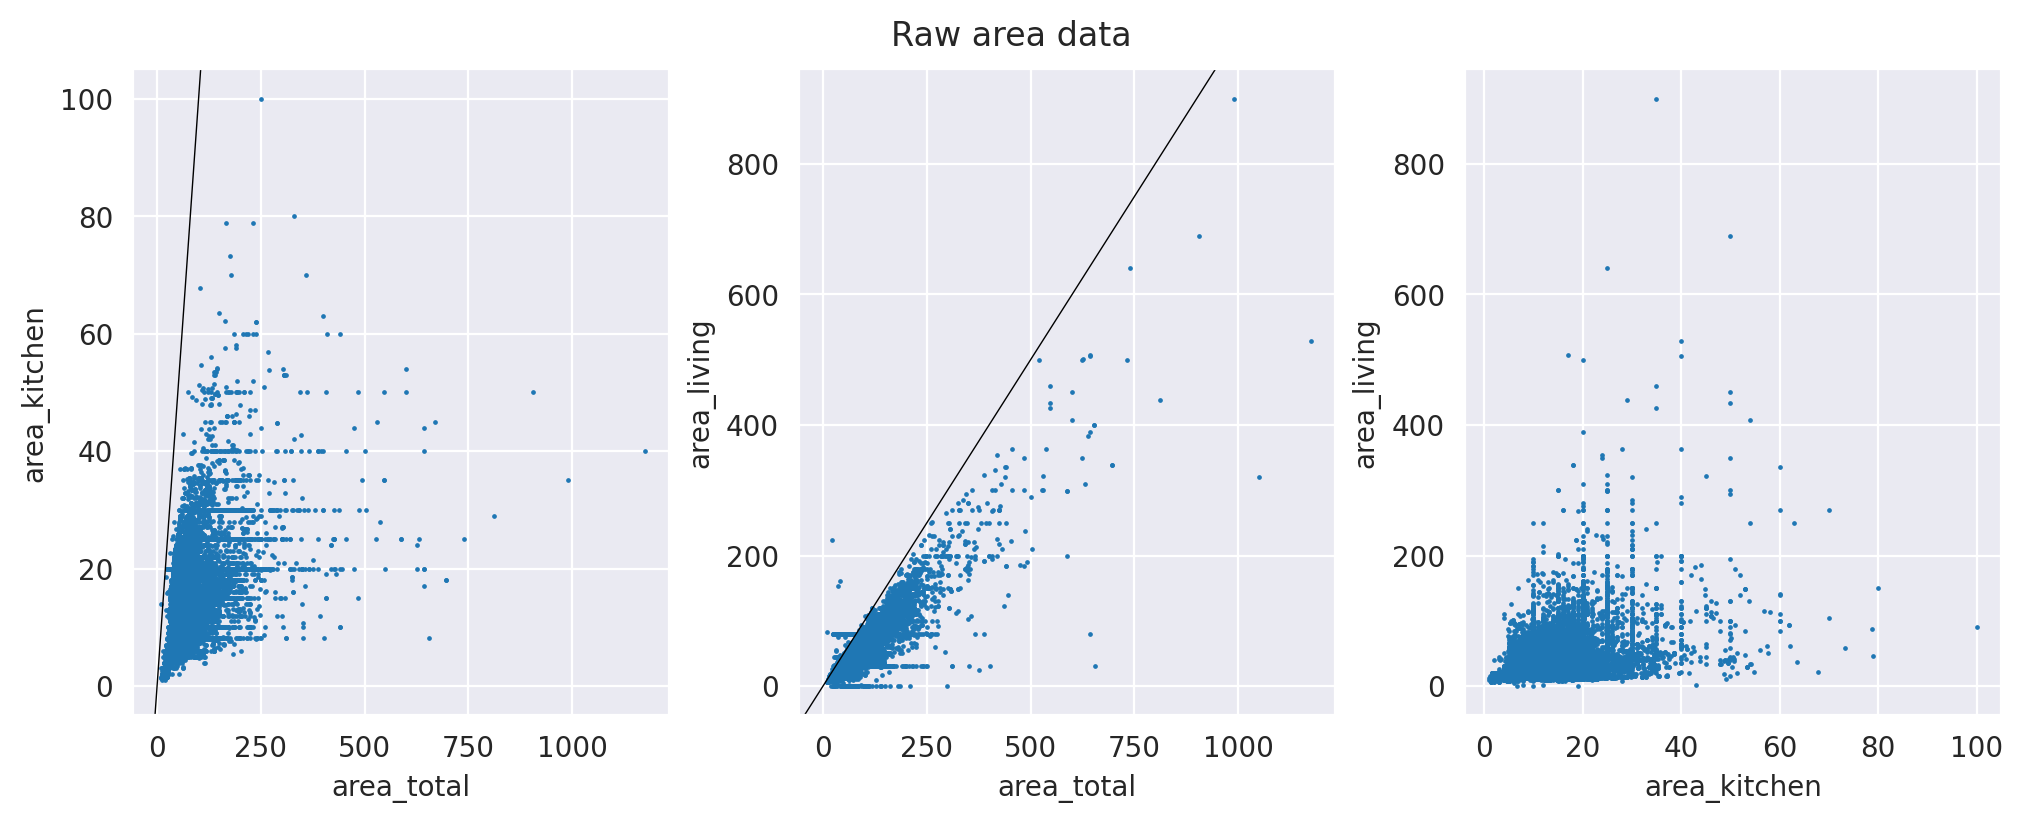

In [5]:
scatter_plot(numerical_data, 'area_total', 'area_kitchen', 'area_living', 'Raw area data')

It looks like the area data contains two distinct superimposed distribution types. This might be caused by erroneous data, different data definition usages, etc. Specifically, there seems to be one semi-normal distribution and one heavily quantized distribution. Escpecially the horizontal lines in the living-total plane is suspicious. We made an algorithm to delete some of this data, which are later imputed. This data deletion showed improvements with all models.

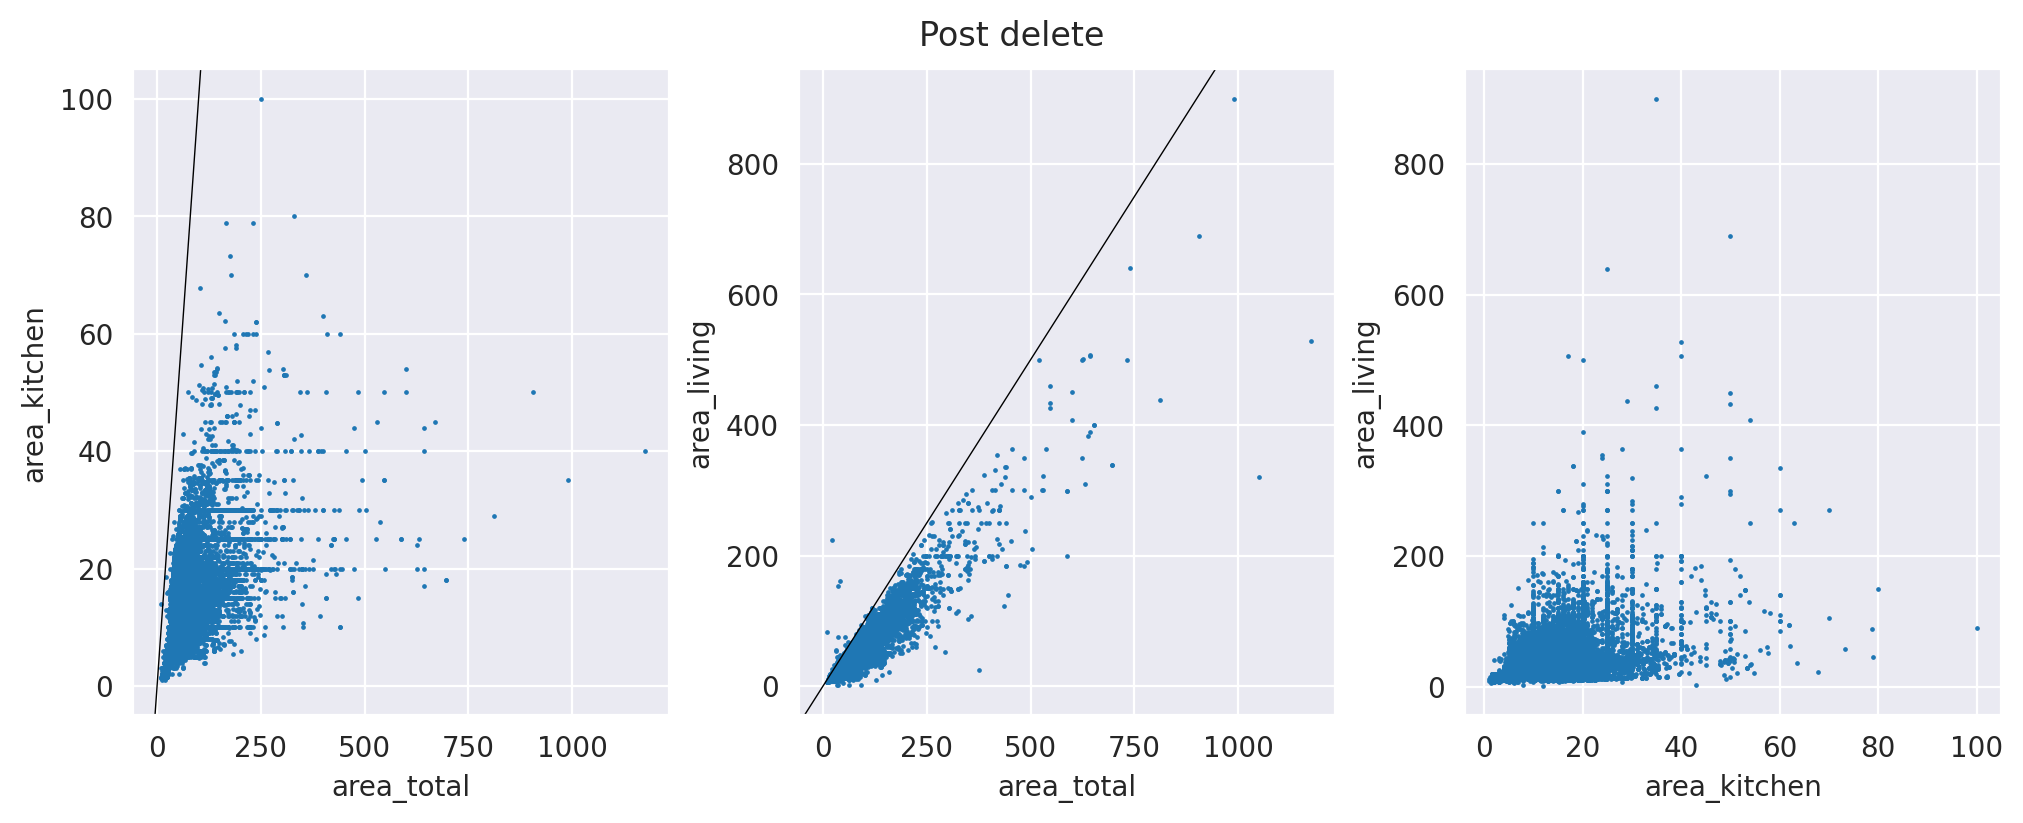

In [8]:
scatter_plot(numerical_data, 'area_total', 'area_kitchen', 'area_living', 'Post delete')

With this we were able to delete some of the suspicious data: The 0 area living room areas as well as the repeating cluster patterns in the data. Some seemingly overly quantized data remains, but removing these lines as well did not show improvements for tree-based models.

##### Imputing (covariance)

Another idea we had, was to impute the area data with the statistically most likely value given by the covariance. The following method is inspired by a discussion on stackexchange: [Imputing data using covariance](https://stats.stackexchange.com/questions/480990/imputing-data-using-covariance)

In general, for an observational vector $x$ with $m$ missing values and $o$ observed values where the covariance matrix $C$ is known, the following method produces the best guess, even if the actual distribution of the data is not know (could be normal, or something else). First, partition the mean vector $\mu$ into $$\mu = [\mu_m~~\mu_o]^T,$$ and the covariance matrix $C$ into $C_{mm}$ and $C_{oo}$, where $m$ indicate missing values, and $o$ observed values. Then the best guess for the missing values $x_m$ is $$x_m=\mu_m + C_{mo}C_{oo}^{-1}(x_0 - \mu_0).$$ If the data is standardized, then this simplifies to $$x_m=C_{mo}C_{oo}^{-1}x_0.$$

The following methods implements this method (original work).

In [11]:
def impute_with_covariance(X):
    # Standardize first
    means = X.mean()
    stds = X.std()
    for column in X:
        X.loc[:, column] = (X[column] - means[column]) / stds[column]
    covariance_matrix = X.cov()

    # Calculate and impute
    null_rows = []
    for i in range(len(X)):
        for column in X:
            if pd.isnull(X.at[i, column]):
                null_rows.append(i)
                break
    for i in null_rows:
        missing_columns = []
        observed_columns = []
        observed_values = []
        for column in X.columns:
            if pd.isnull(X.at[i, column]):
                missing_columns.append(column)
            else:
                observed_columns.append(column)
                observed_values.append(X.at[i, column])
        m = len(missing_columns)
        o = len(observed_columns)
        cov_mo = np.ndarray([m, o], dtype=np.float64)
        cov_oo = np.ndarray([o, o], dtype=np.float64)
        observed_values = np.array(observed_values)
        for m_i, m_col in enumerate(missing_columns):
            for o_i, o_col in enumerate(observed_columns):
                cov_mo[m_i, o_i] = covariance_matrix.at[m_col, o_col]
        for o_i, o_col_i in enumerate(observed_columns):
            for o_j, o_col_j in enumerate(observed_columns):
                cov_oo[o_i, o_j] = covariance_matrix.at[o_col_i, o_col_j]
        missing_values = np.matmul(np.matmul(cov_mo, np.linalg.inv(cov_oo)), observed_values)
        for m_i, m_col in enumerate(missing_columns):
            X.at[i, m_col] = missing_values[m_i]

    # Un-standarize
    for column in X:
        X.loc[:, column] = X[column] * stds[column] + means[column]
    
    return X

In [12]:
X = numerical_data.copy()
X = impute_with_covariance(X)

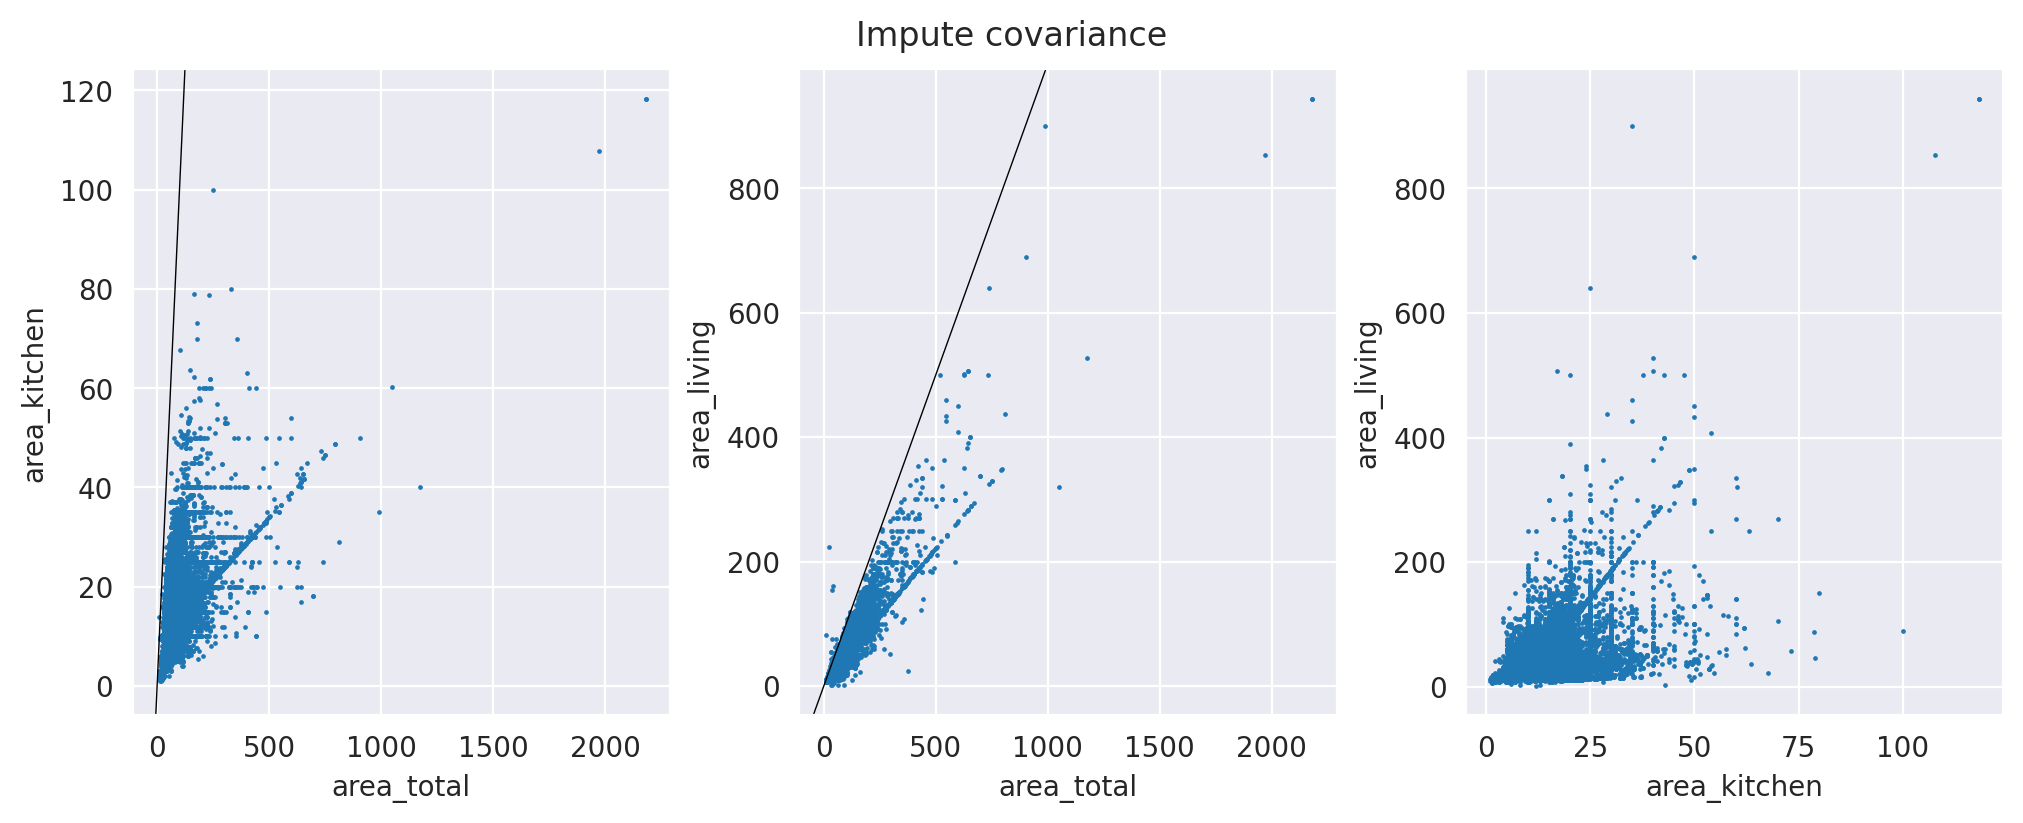

In [13]:
scatter_plot(X, 'area_total', 'area_kitchen', 'area_living', 'Impute covariance')

Although the imputed values look very sensible, this does not work very well with tree-based models. Our understanding of this is that the covariance-imputed values interferes with the quantized distribution in the data, and thus only serves to confuse the models by obscuring the patterns that are present. Therefore, we have been using quantile imputed values in our top models.

#### EDA: Geography

This notebook explore the georgraphical relationships in the data. Besides the obvious distance from Moscow centre, we look for other geographical patterns in the data.

(<AxesSubplot:title={'center':'District_Center_Dist by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x7f341b106d30>)

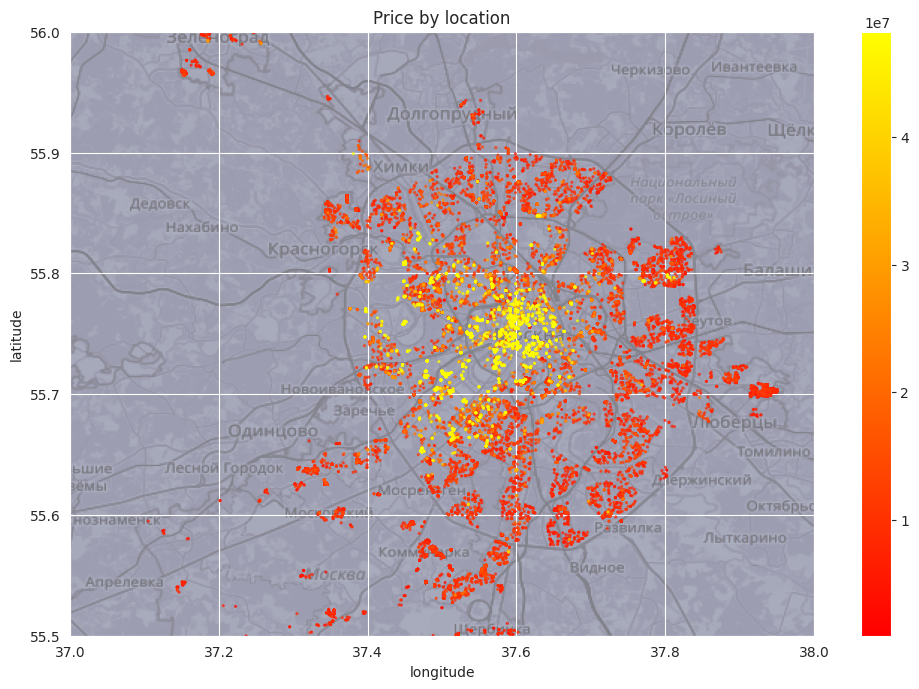

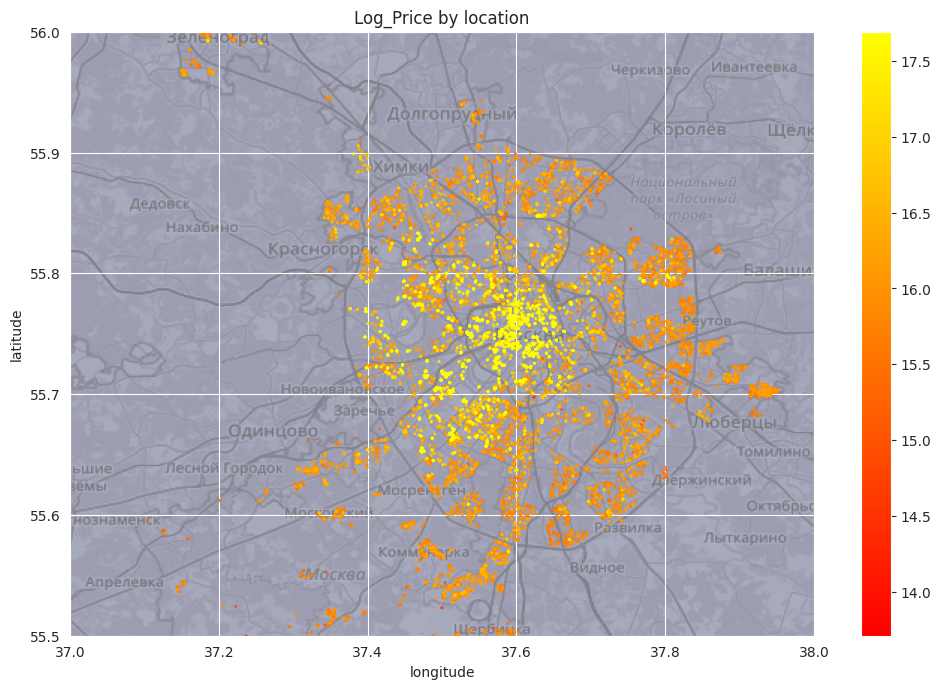

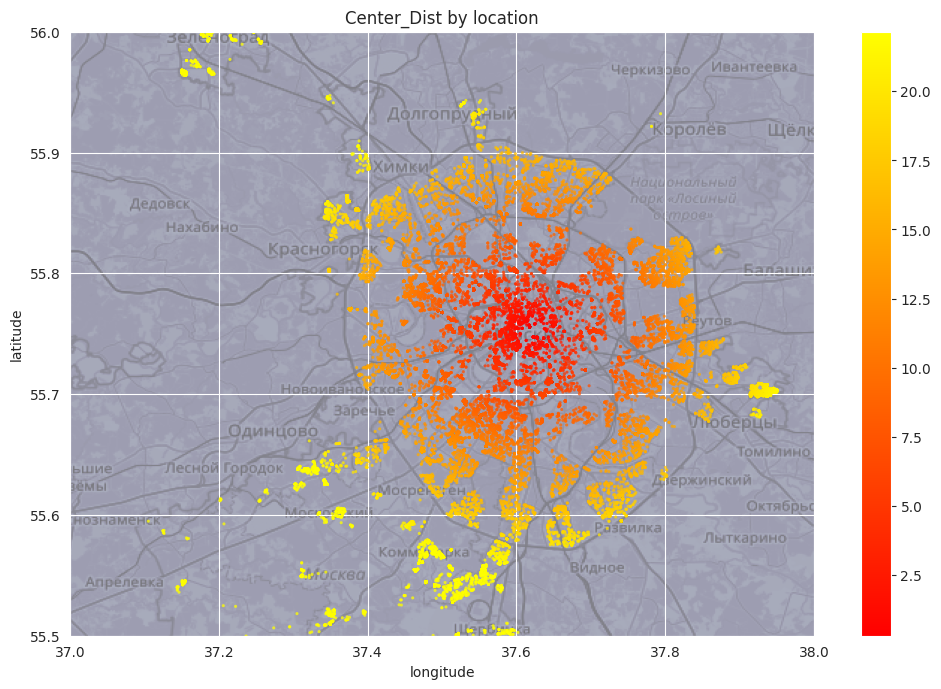

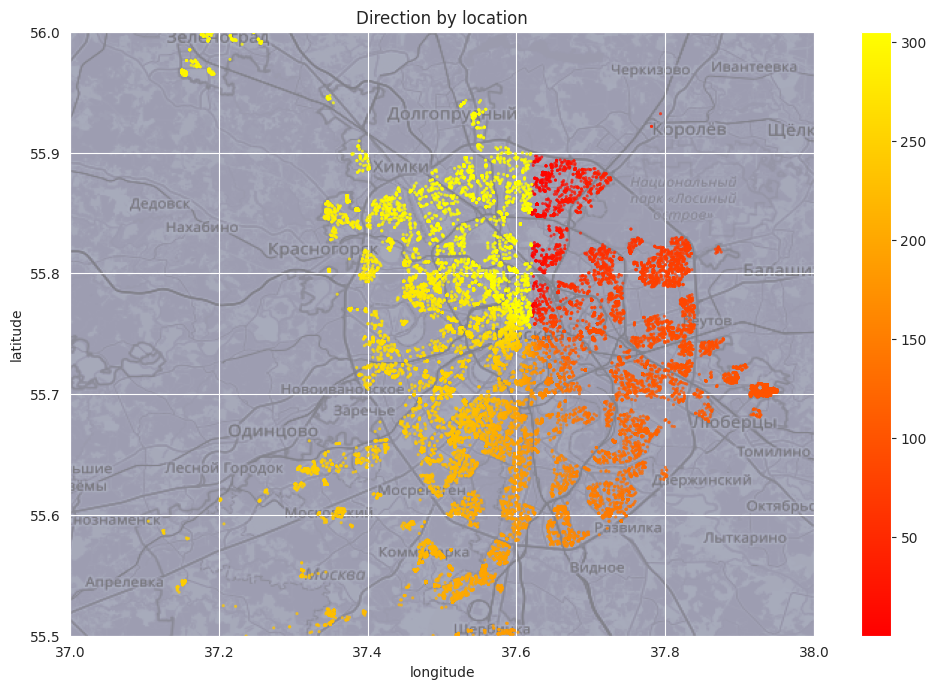

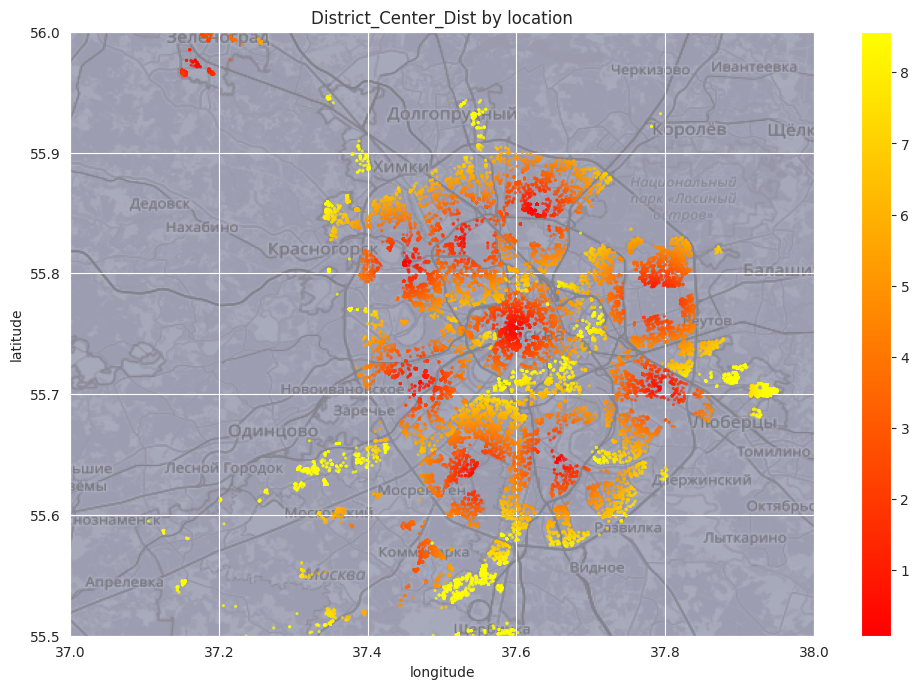

In [9]:
geo_data = X.copy()
geo_data['price'] = data.loc[:, 'price']
geo_data['log_price'] = np.log1p(data['price'])

plot_map(geo_data, column='price')
plot_map(geo_data, column='log_price')
plot_map(geo_data, column='center_dist')
plot_map(geo_data, column='direction')
plot_map(geo_data, column='district_center_dist')

(<AxesSubplot:title={'center':'Log_Price by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x7f341a83ef40>)

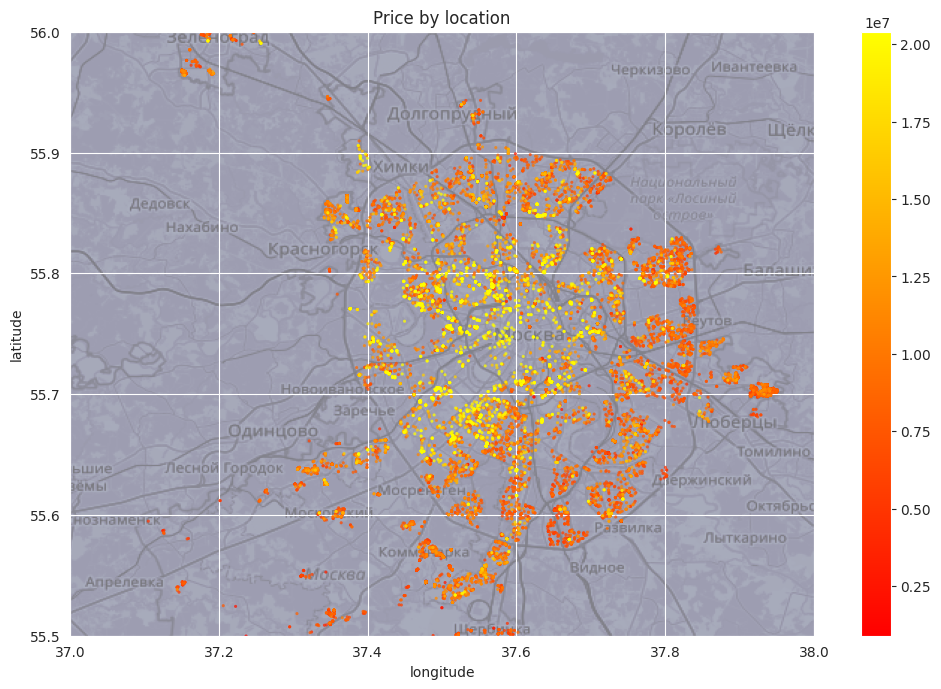

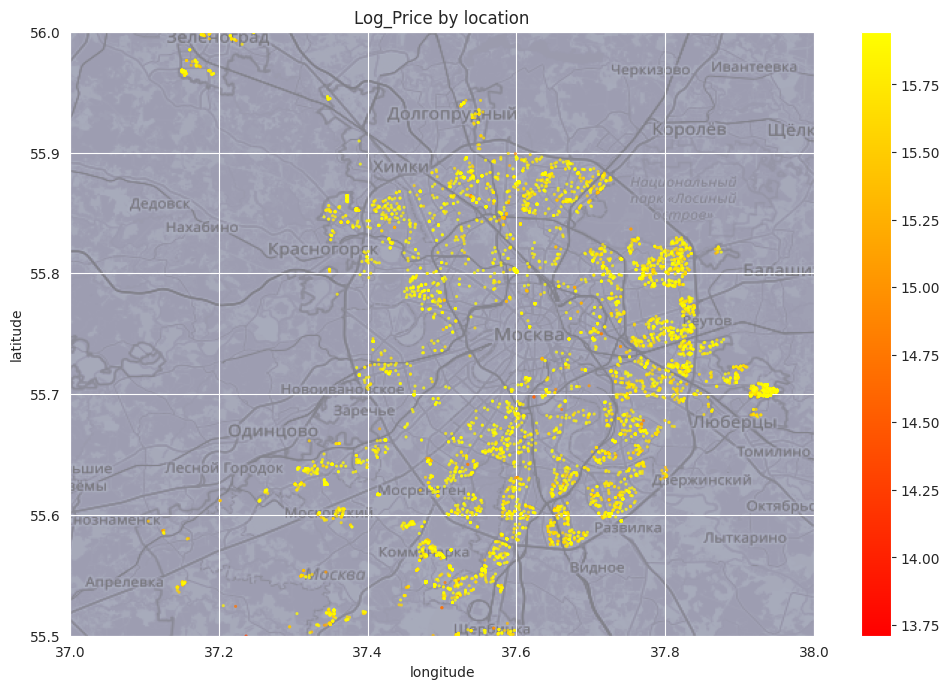

In [10]:
# Take away the highest priced buildings to look for patterns with higher depth
plot_map(geo_data.loc[geo_data['price'] < 30000000], column='price')
plot_map(geo_data.loc[geo_data['log_price'] < 16], column='log_price')

Looks like there is an increased price to the north-west. Upon inspection, this is near Sjeremetjevo international airport (55.9678, 37.3818).

Another interesting location is the Izmaylovo park (55.7768, 37.7938).

The curch Khram pok. Might also be worth testing (55.7055, 37.9281).

There seems to be a very commercial district around (55.5478, 37.5529).

Including the distance to the above locations as engineered features, showed major improvements to our predictions.

## Attempted models and hyperparameter tuning

Besides the models used in the stacking pipeline in the short notebook (and used for our second best selected solution), we tried a couple of other, also tree-based ensemble predictors. Namely, these were Extra Trees and XGBoost, which didn't lead to a consistent improvement of our score, so we decided not to include them in the final solution.

In [15]:
model5 = ExtraTreesRegressor(
    max_features=0.8192305914534288,
    max_leaf_nodes=22090,
    n_estimators=1207,
    n_jobs=-1,
    random_state=SEED
)

model6 = xgb.XGBRegressor(
    objective ='reg:linear',
    colsample_bytree=0.8845857323642652,
    learning_rate=1.0,
    reg_alpha=0.008887062685209992,
    reg_lambda=256.69079001388224,
    n_estimators=23284,
    max_leaves=17,
    min_child_weight=0.0023510272419501274,
    subsample=0.9014604158435371,
    colsample_bylevel=0.6765332382499811,
    seed=SEED
)

For fine tuning the predictor hyperparameters, we realized early on that manual attempts, besides being tedious, are very ineffective. We simultaneously tried 2 popular AutoML libraries - Optuna nad FLAML. Since FLAML worked better out-of-the box, we used that for obtaining our models. We believe we would be able to attain similar results with Optuna, if we invested enough time in finer-grained experiments. We are also aware of grid search methodology, but we felt it was not time-efficient compared to AutoML.

Examples of running Optuna and FLAML on the dataset are given below.

##### Optuna example

In [4]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold

In [8]:
GROUPS = data['building_id'].astype('int32')
N_FOLDS = 5
SEED = 123
OUTLIER_LIMIT = 20

def objective(trial, X, y):
    param_grid = {
        "metric": "RMSLE",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 30000, step=100), # best we know: 23284
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3), # best we know: 0.038772388344039496
        "max_bin": trial.suggest_categorical("max_bin", [255, 512, 1023]), # best we know: 1023
#         "max_depth": trial.suggest_int("max_depth", 3, 12), # best: -1 (default, no limit)
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0), # same as reg_alpha, best we know: 0.003539069387982963
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0), # same as reg_lambda, best we know: 7.774356662353698
        "num_leaves": trial.suggest_int("num_leaves", 2, 512), # best we know: 38
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0), # same as colsample_bytree, best performing we know: 0.8346198485840488
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100), # same as min_child_samples, best we know: 17
    }

    sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    y = y.round()
    y[y > OUTLIER_LIMIT] = OUTLIER_LIMIT + 1
    rmsle_scores = np.empty((N_FOLDS,))
    
    for idx, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=GROUPS)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMRegressor(verbose=-1, random_state=123, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=mhu.rmsle_lgbm2,
            categorical_feature=cat_idx,
            early_stopping_rounds=1000,
            callbacks=[
                LightGBMPruningCallback(trial, "RMSLE")
            ],  # Add a pruning callback
        )
        
        y_hat = model.predict(X_test) # predict on the test set
        # replace negative predictions with zeroes
        if (y_hat < 0).any():
            print("WARNING: Negative prediction(s) given!")
            print(y_hat[y_hat < 0])
            y_hat[y_hat < 0] = 0
        
        rmsle_scores[idx] = mhu.rmsle(y_true=y_test, y_pred=y_hat, logged=True)

    return rmsle_scores.mean(axis=0)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=50)

Output is cleared since it represented over two thirds of this notebook's size, and wasn't particularly insightful. We couldn't get RMSLE far below 0.3, which is when we decided FLAML is more effective.

##### FLAML example - optimizing meta-regressor for ensemble stacking

In [19]:
automl = AutoML()

runtime = 600
automl_settings = {
    "time_budget": runtime,  # in seconds
    "estimator_list": "auto",  # list of ML learners
    "metric": "rmse",
    "task": "regression",
    "log_training_metric": True,
    "log_file_name": "auto.log",
    "seed": SEED
}

automl.fit(X_train=x_train_meta, y_train=y_train,
           **automl_settings)

[flaml.automl: 11-19 16:32:00] {1458} INFO - Data split method: uniform
[flaml.automl: 11-19 16:32:00] {1462} INFO - Evaluation method: cv
[flaml.automl: 11-19 16:32:00] {1510} INFO - Minimizing error metric: rmse
[flaml.automl: 11-19 16:32:00] {1547} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 11-19 16:32:00] {1777} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-19 16:32:00] {1894} INFO - Estimated sufficient time budget=1257s. Estimated necessary time budget=3s.
[flaml.automl: 11-19 16:32:00] {1966} INFO -  at 0.2s,	estimator lgbm's best error=0.6053,	best estimator lgbm's best error=0.6053
[flaml.automl: 11-19 16:32:00] {1777} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 16:32:00] {1966} INFO -  at 0.3s,	estimator lgbm's best error=0.6003,	best estimator lgbm's best error=0.6003
[flaml.automl: 11-19 16:32:00] {1777} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 16:32:00] {19

In [20]:
# automl_predictions = automl.predict(X_test)

# Print the best model
print(automl.model)

# Retrieve best config and best learner
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
automl.model.estimator

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 154, 'max_features': 0.6679422374183948, 'max_leaves': 161}
Best accuracy on validation data: 0.8814
Training duration of best run: 1.17 s


ExtraTreesRegressor(max_features=0.6679422374183948, max_leaf_nodes=161,
                    n_estimators=154, n_jobs=-1)

##### Other attempts

We also tried using sklearn's StackingCVRegressor, but we found it too constraining for our needs, and we opted instead for using our own implementation (which, to be fair, is heavily inspired by a notebook used in one of the lectures).

In [28]:
# create train and test datasets
unused_features = ['address', 'building_id']
X_train = data.drop(unused_features + ['price'], axis=1)
y_train = np.log1p(data.price)
X_test = data_test.drop(unused_features, axis=1)

# merge train and test for combined data processing
X = X_train.append(X_test, ignore_index=True)
X = data_wrangling_optimal(X)

##############################################################################
# change what is different in data processing from best LGBM pipeline

# OHE categorical features
ints = int_cols.copy()
ints.remove('street')
cats = category_cols.copy()
cats.remove('street')
X = pd.get_dummies(X, columns=cats)

# update train and test sets
drop_features = ['elevator_without', 'elevator_service', 'elevator_passenger',
                 'street']
update_train_test(X_train, X_test, all_data=X, drop_features=drop_features)
X_train.drop(cats, axis=1, inplace=True)
X_test.drop(cats, axis=1, inplace=True)
##############################################################################

In [29]:
# models
lgbm = LGBMRegressor(
    colsample_bytree=0.8346198485840488,
    learning_rate=0.038772388344039496,
    max_bin=1023,
    min_child_samples=17,
    n_estimators=23284,
    num_leaves=38,
    reg_alpha=0.003539069387982963,
    reg_lambda=7.774356662353698,
    metric="rmse",
    verbose=-1,
#     categorical_feature=cat_idx,
    random_state=SEED,
)

rf = RandomForestRegressor(
    max_features=0.6913722322623973,
    max_leaf_nodes=23284,
    n_estimators=667,
    n_jobs=-1,
    random_state=SEED
)

catboost = CatBoostRegressor(
    n_estimators=1889,
    learning_rate=0.2,
    thread_count=-1,
    depth=6,
    silent=True,
    bagging_temperature=0.2,
    early_stopping_rounds=63,
#     cat_features=cat_idx,
    random_seed=SEED
)

meta_model = LGBMRegressor(
    num_leaves=5,
    max_depth=7,
    silent=True,
    metric='mse',
    n_jobs=4,
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05,
    random_state=SEED
)

In [30]:
stack = StackingCVRegressor(
    regressors=(lgbm, rf, catboost),
    meta_regressor=meta_model,
    use_features_in_secondary=True,
    random_state=SEED
)
stack.fit(X_train, y_train)
preds_df["scvr"] = np.floor(np.expm1(stack.predict(X_test)))

C:\Users\matey\miniconda3\envs\mlcourse\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


We tried feature engineering with both polynomial and linear feature combinations based on mutual information between features, but most of the ones we tried didn't bring improvement in performance. Some brought no discernible change in score, and we used those in our second LGBM predictor, to replace some of the features most relied on by the best-performing predictor. Admittedly, our predictions for the ensemble stacking models correlate far more strongly than we would like, but we didn't have enough time to explore how to make them more different.

## Interpretation and explainability

### Mean decrease in impurity / Gini importance

Since we used solely tree-based predictors, we found Gini importance of features to be very helpful both when determining which features to focus on during feature engineering, and when picking feature combinations for stacking.

Here are Gini importance graphs for all 5 predictors in the short notebook.

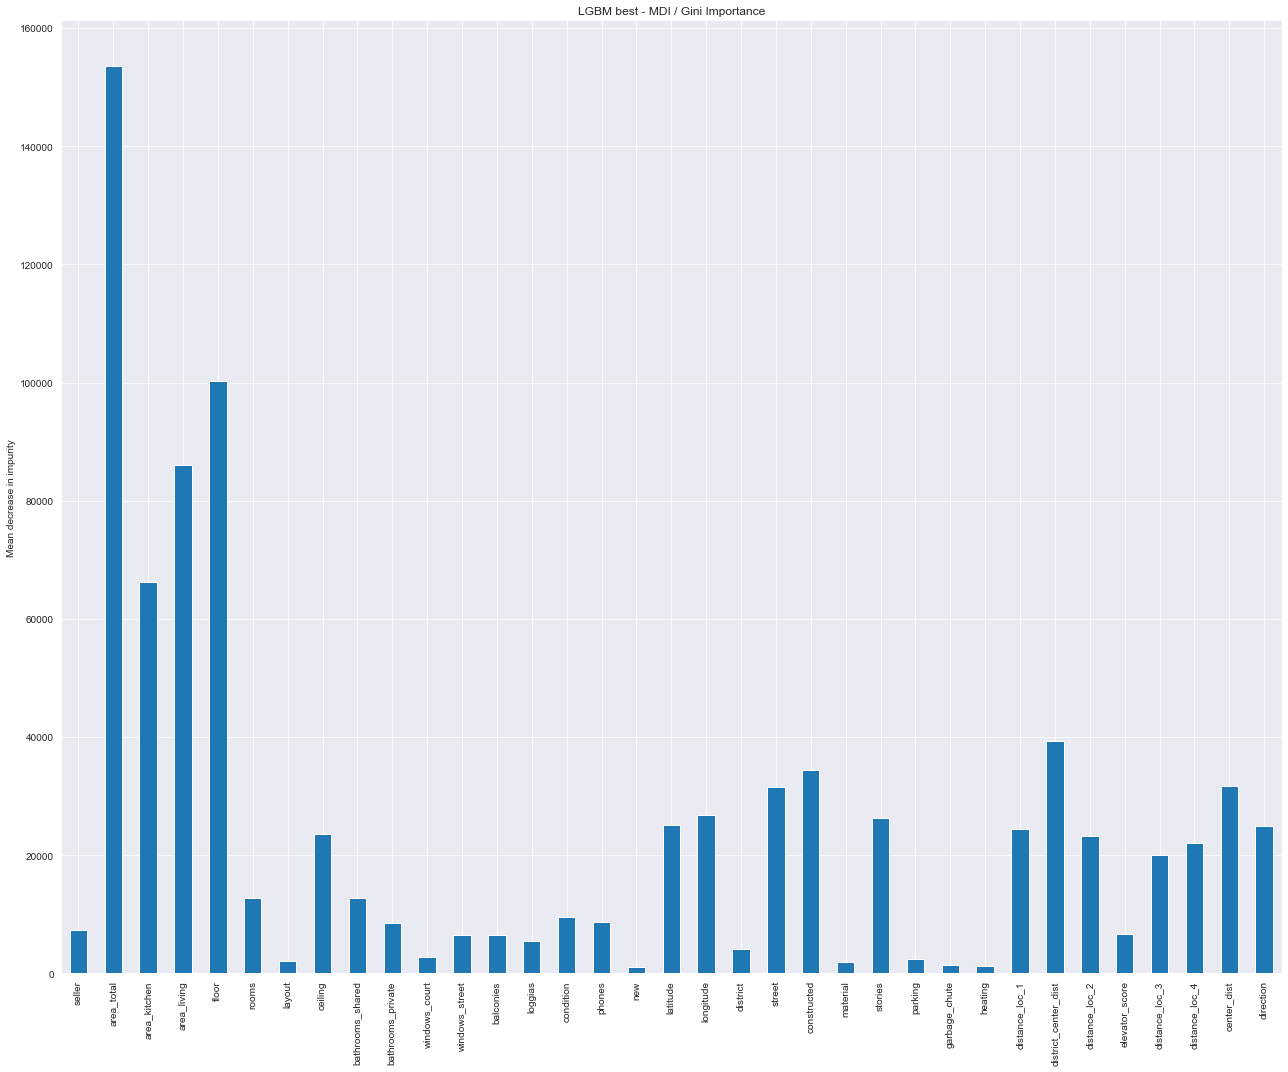

In [10]:
plot_feature_importances(model0, "LGBM best", cols=X_train.columns)

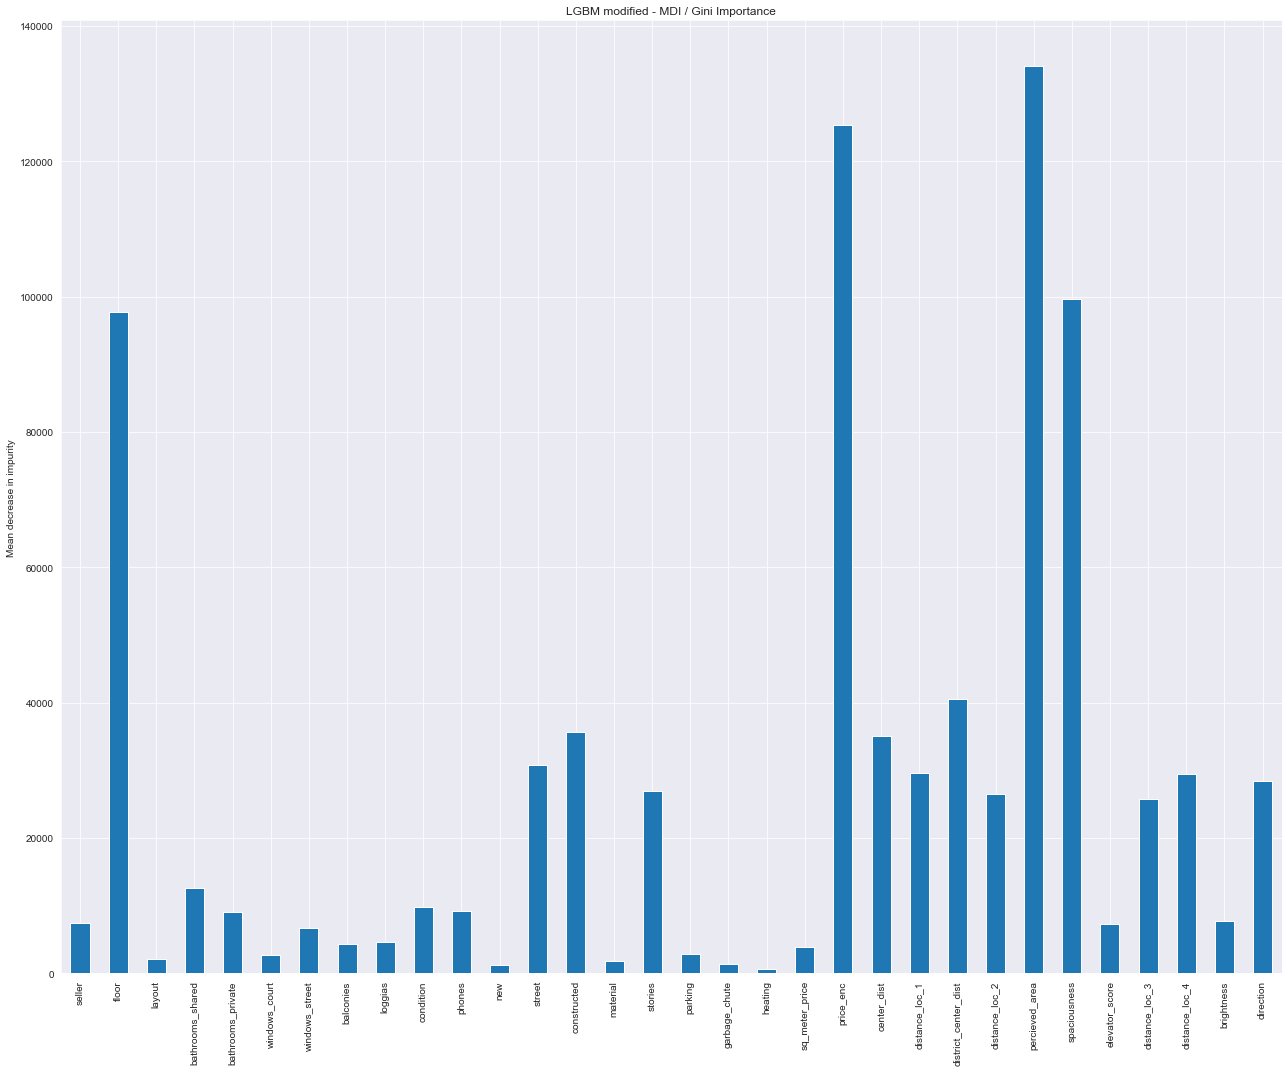

In [13]:
plot_feature_importances(model1, "LGBM modified", cols=X_train.columns)

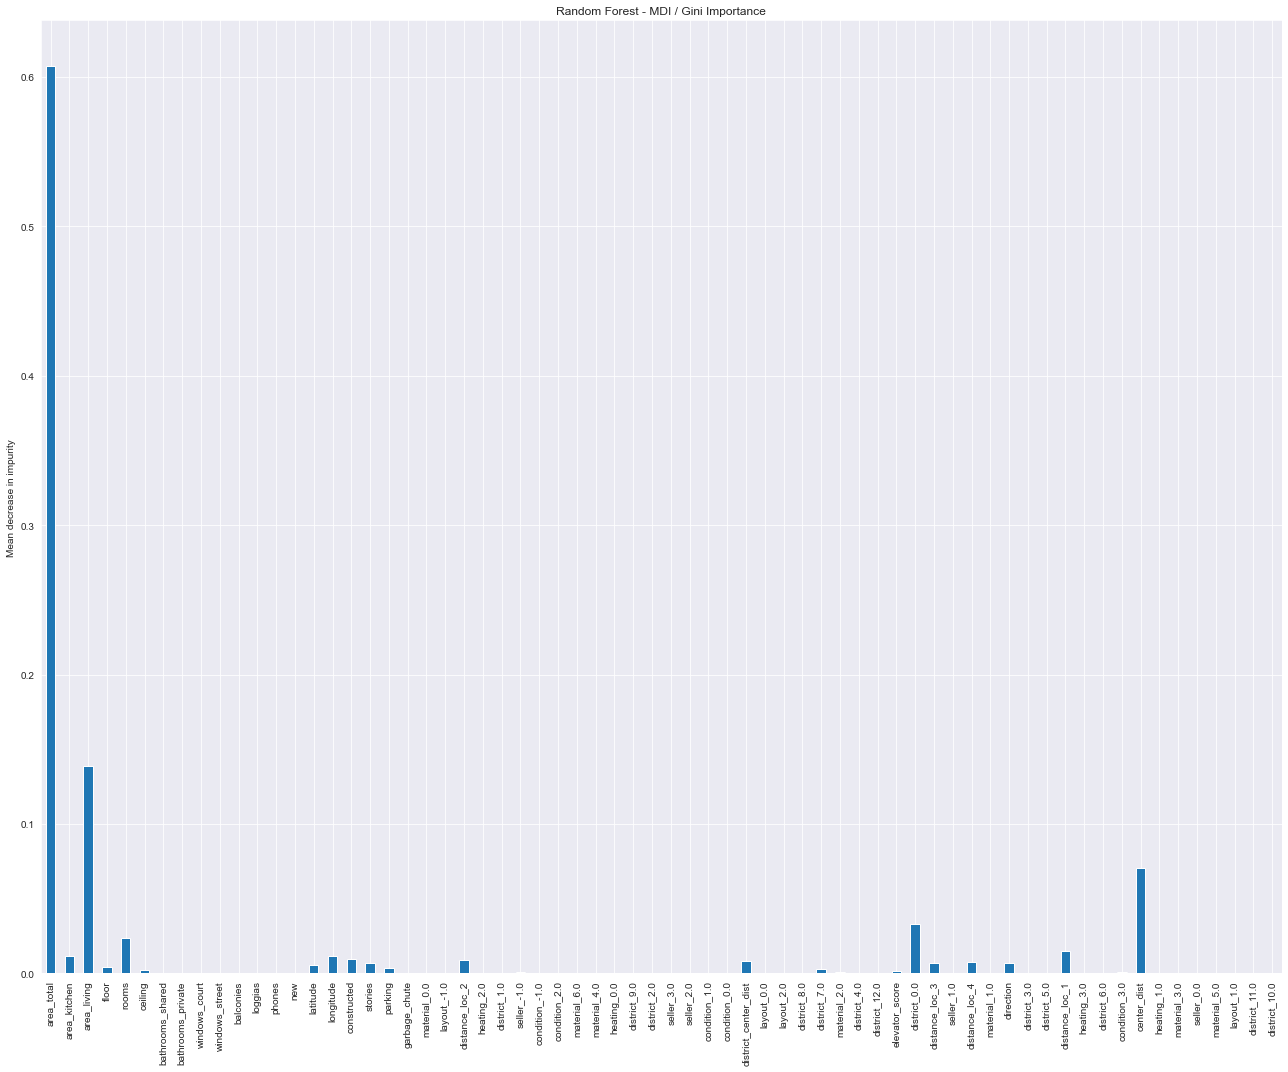

In [17]:
plot_feature_importances(model2, "Random Forest", cols=X_train.columns)

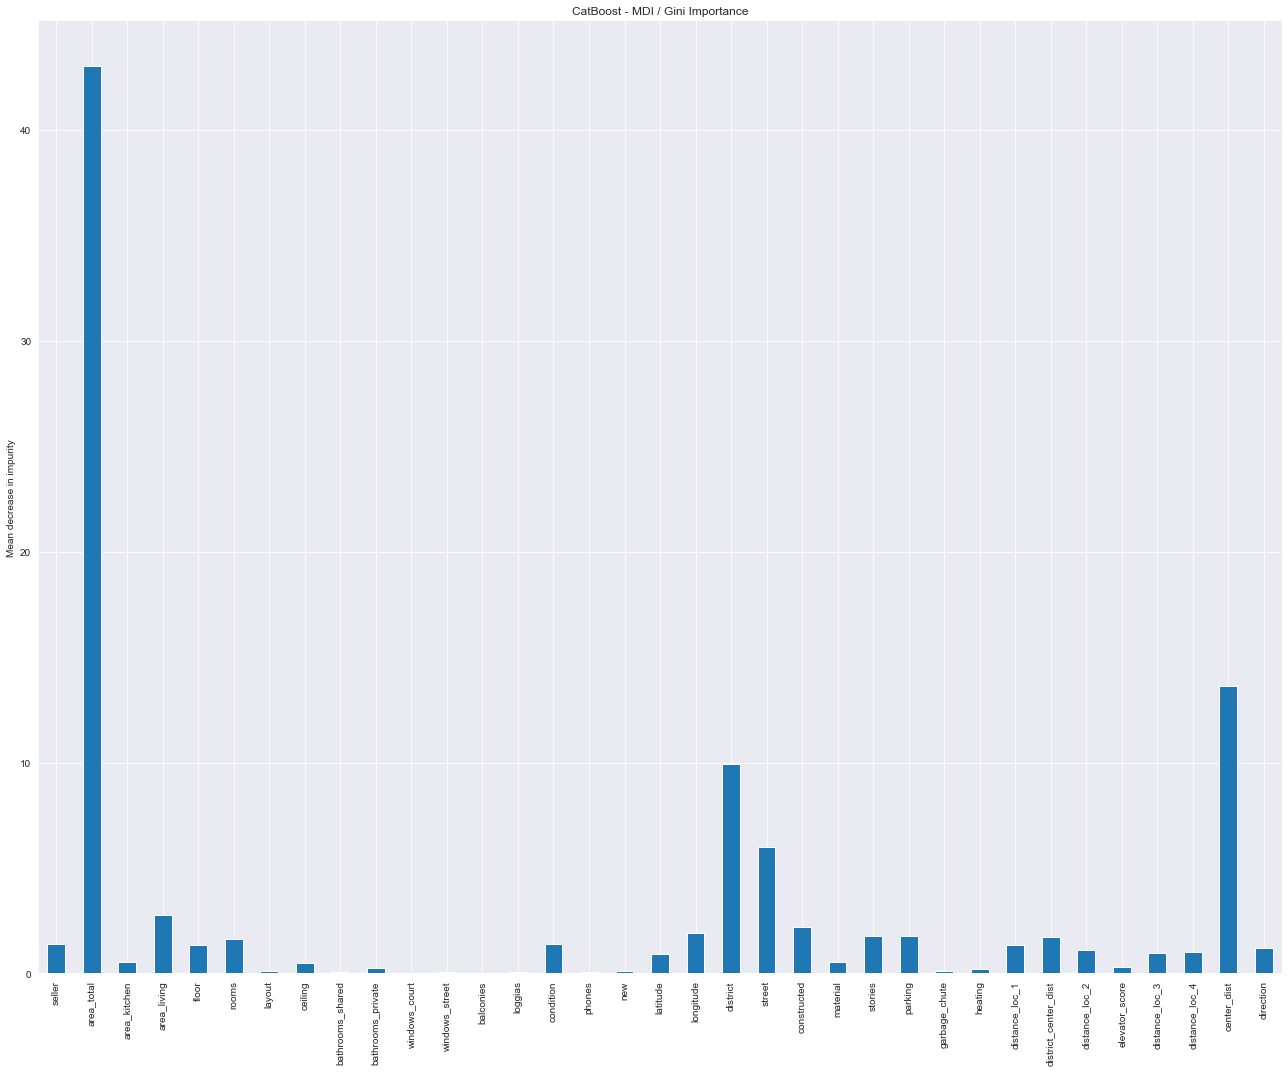

In [21]:
plot_feature_importances(model3, "CatBoost", cols=X_train.columns)

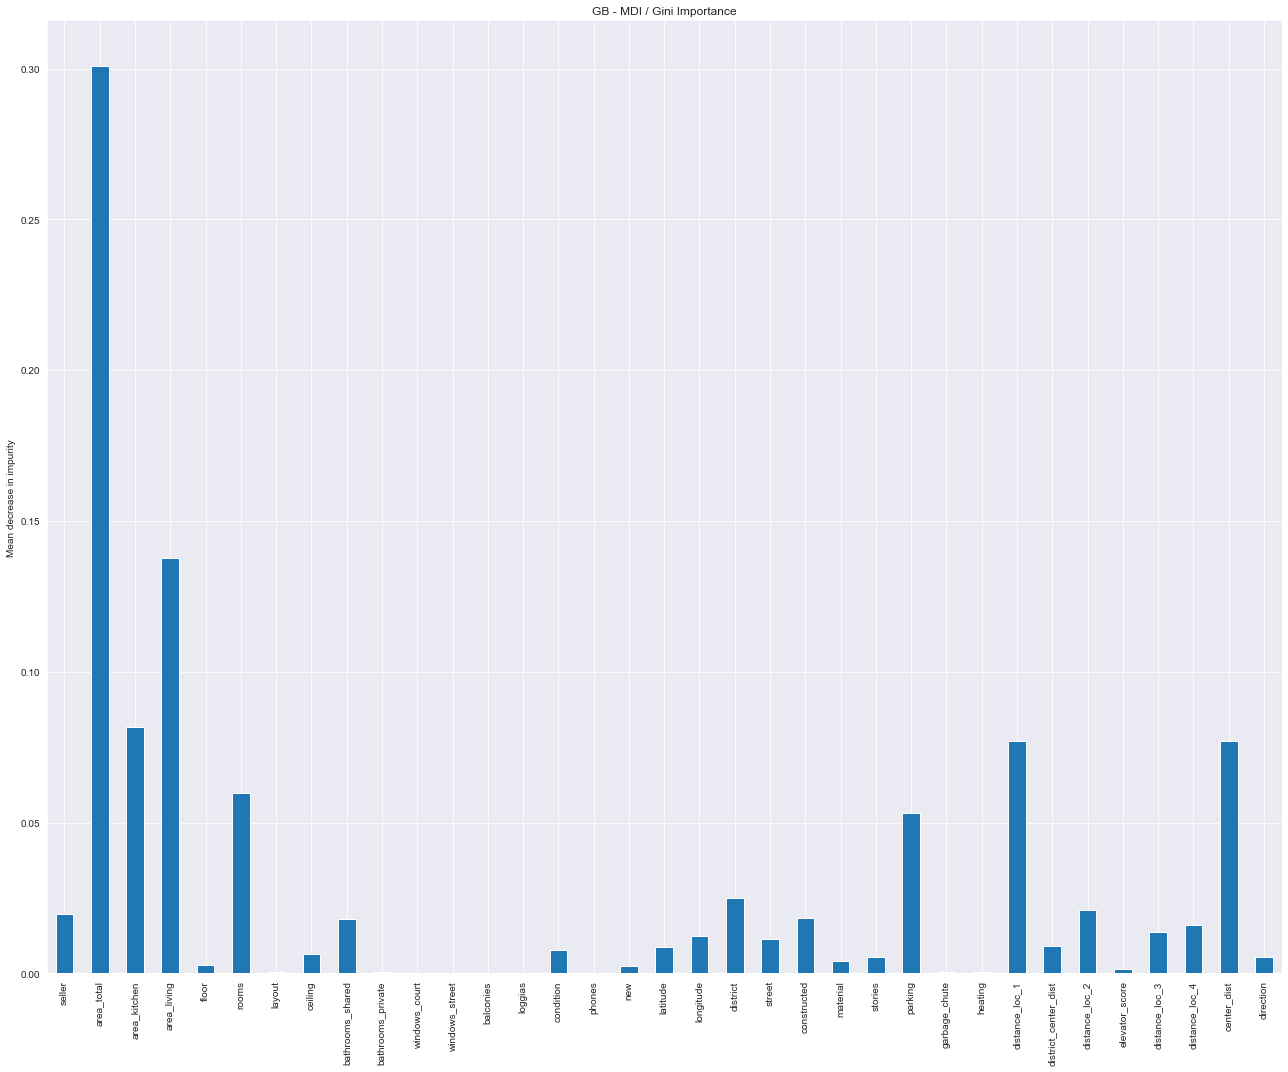

In [24]:
plot_feature_importances(model4, "GB", cols=X_train.columns)

### LIME

Later on in the competition, we found out about LIME in the lectures, and it also provided a more detailed insight into the effect the features have in specific models, depending on the apartment in the dataset.

Below is an example for the first apartment in the test dataset, for Random Forest and the best LGBM predictor.

In [9]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_model0.values,
                                                   feature_names=X_train_model0.columns,
                                                   class_names=["price"],
                                                   categorical_features=cat_idx,
                                                   categorical_names=category_cols,
                                                   verbose=True,
                                                   mode="regression"
                                                  )
i = 0 # example instance index
exp = explainer.explain_instance(X_train_model0.iloc[i], model0.predict, num_features=10)

Intercept 16.69133319437664
Prediction_local [15.47356203]
Right: 15.737288835022204


![Example LIME output](img/lime_output.png)

In [11]:
exp.as_list()

[('center_dist > 16.50', -0.43151203108916847),
 ('42.00 < area_total <= 59.80', -0.3815411582778122),
 ('street=0', -0.203284247515793),
 ('0.00 < parking <= 1.00', -0.10087031271419028),
 ('longitude <= 37.50', 0.0757125034539468),
 ('district=11', -0.06941335800211682),
 ('floor <= 3.00', -0.06728173749184221),
 ('1.00 < rooms <= 2.00', 0.04998021411338922),
 ('stories <= 9.00', -0.04704912293811452),
 ('latitude <= 55.66', -0.04251191449890227)]

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_model2.values, feature_names=X_train_model2.columns, class_names=["price"], verbose=True, mode="regression")
i = 0 # example instance index
exp = explainer.explain_instance(X_test_model2.iloc[i], model2.predict, num_features=10)

Intercept 17.055206520326358
Prediction_local [16.97428272]
Right: 17.203223180535453


C:\Users\matey\miniconda3\envs\mlcourse\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


![Example LIME output](img/lime2.png)

In [13]:
exp.as_list()

[('center_dist <= 7.09', 0.37554010638562313),
 ('heating_2.0 <= 0.00', -0.19662261713383536),
 ('district_0.0 > 0.00', 0.155168703769745),
 ('material_5.0 <= 0.00', -0.12002107859258943),
 ('heating_3.0 <= 0.00', 0.10242813149288098),
 ('37.50 < longitude <= 37.57', 0.0862647600490855),
 ('district_8.0 <= 0.00', -0.08019937900893254),
 ('district_7.0 <= 0.00', -0.06783377798719858),
 ('district_11.0 <= 0.00', 0.0635399338481788),
 ('material_3.0 <= 0.00', 0.05705553519286537)]

This output clearly shows which feature had positive or negative effect, and to what degree, when predicting the price of the apartment. In effect, it explains the underlying (ensemble) decision tree.

## Validation

Reliable validation was extremely challenging after beating first few virtual teams on the public leaderboard. First, we would overfit regularly. When we realized (thanks to a hint from the TAs) that it was in large part due to the inferred connections between apartments in the same buildings, we used GroupKFold and StratifyGroupKFold from sklearn during validation to have apartments in the hold-out set only from the building not in the rest of the data used for training.

However, this also proved to be fairly misleading in the top half of the leaderboard when gauging the impact of the newly-engineered features.

It would have been virtually impossible to come up with effective solutions without the increased daily submission limit, and we think this decision was very justified since reliable (local) validation was impossible for marginal improvements in score.

We were also able to confirm that the split to test and train set was __not random__, since there is no overlap in buildings between the datasets.

In [19]:
data.building_id.isin(data_test.building_id).any()

False

## Note about reproducibility

During development of our pipeline, we strived to keep our code completely reproducible. However, we were able to achieve our best results in the past day, and with them, we have introduced an unkown source of randomness in our code, which makes it non-deterministic, with small variations in the RMSLE score for predicted prices. With the deadline hours away, we are unable to pinpoint the cause of this. Still, we _have_ generated the predictions with the provided code, so we believe this result, and the chosen solutions, to still be valid.

If the course staff objects to this, we will accept the output of your own random run of our script as our final submission.